# Embeddings

In [64]:
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from natsort import natsorted
import os
from PIL import Image
from scipy.stats import pearsonr

In [65]:
# EMB_DIR = '../datasets/embeddings'
TRAIN_DIR = '../data/hpicked_ssnet_train/train'
VAL_DIR = '../data/hpicked_ssnet_val/validation/'

device = torch.device("mps")

resnext = torchvision.models.resnext101_32x8d(torchvision.models.ResNeXt101_32X8D_Weights.IMAGENET1K_V2).to(device)
resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT).to(device)

/Users/lucasgomez/opt/miniconda3/envs/bashlab_cogenv/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [66]:
cats = ['boats','cars', 'lights', 'airplanes', 'couches', 'chairs']
def read_data(path, img_per=3):
    
    cats_dict = {
        'boats' : [],
        'cars' : [],
        'lights' : [],
        'airplanes' : [],
        'couches' : [],
        'chairs' : [],
        }

    cat = 0
    count = 0

    fps = os.listdir(path)
    if '.DS_Store' in fps:
        fps.remove('.DS_Store')
    if '.ipynb_checkpoints' in fps:
        fps.remove('.ipynb_checkpoints')

    for fp in natsorted(fps):
        fp = os.path.join(path, fp)
        for img_fp in os.listdir(fp):
            img_fp = os.path.join(fp, img_fp)
            if img_fp[-4:] == '.png':
                img = np.rollaxis(np.array(Image.open(img_fp), dtype=np.float32),2,0)
                cats_dict[cats[cat]].append(img)
        count += 1
        if count%img_per == 0:
            cat += 1
    return cats_dict

In [67]:
train_boats = torch.Tensor(np.array(read_data(TRAIN_DIR,3)['boats'])).to(device)
train_cars = torch.Tensor(np.array(read_data(TRAIN_DIR,3)['cars'])).to(device)
train_lights = torch.Tensor(np.array(read_data(TRAIN_DIR,3)['lights'])).to(device)
train_airplanes = torch.Tensor(np.array(read_data(TRAIN_DIR,3)['airplanes'])).to(device)
train_couches = torch.Tensor(np.array(read_data(TRAIN_DIR,3)['couches'])).to(device)
train_chairs = torch.Tensor(np.array(read_data(TRAIN_DIR,3)['chairs'])).to(device)

train_objects = [train_boats,train_cars,train_lights,train_airplanes,train_couches,train_chairs]

In [189]:
list(resnext.named_children())

[('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('relu', ReLU(inplace=True)),
 ('maxpool',
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 ('layer1',
  Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel

In [215]:
def img_encoder(model, objects):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    model.layer4[2].conv3.register_forward_hook(get_activation('layer'))

    with torch.no_grad():
        boat_embs = model(objects[0])
        boat_embs = torch.squeeze(activation['layer'])

        cars_embs = model(objects[1])
        cars_embs = torch.squeeze(activation['layer'])

        lights_embs = model(objects[2])
        lights_embs = torch.squeeze(activation['layer'])

        airplanes_embs = model(objects[3])
        airplanes_embs = torch.squeeze(activation['layer'])

        couches_embs = model(objects[4])
        couches_embs = torch.squeeze(activation['layer'])
        
        chairs_embs = model(objects[5])
        chairs_embs = torch.squeeze(activation['layer'])

    return torch.cat((boat_embs,cars_embs, lights_embs, airplanes_embs, couches_embs, chairs_embs))

In [216]:
train_objects[0].shape

torch.Size([3, 3, 224, 224])

In [217]:
img_encoder(resnext, train_objects).shape

torch.Size([18, 2048, 7, 7])

In [208]:
list(resnext.named_children())

[('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('relu', ReLU(inplace=True)),
 ('maxpool',
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 ('layer1',
  Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel

# RDMs

In [69]:
train_embs = img_encoder(resnext, train_objects)

def construct_RDM(activations):
	num_images = len(activations)
	print(num_images)
	RDM = np.zeros((num_images, num_images))

	for x in range(num_images):
		for y in range(num_images):
			if x<=y:
				correl = 1 - (pearsonr(activations[x].cpu().detach().numpy().flatten(), activations[y].cpu().detach().numpy().flatten()))[0]
				RDM[x][y] = correl
				RDM[y][x] = correl
	return RDM.astype(float)

rdm = construct_RDM(train_embs)

18


In [70]:
rdm.shape

(18, 18)

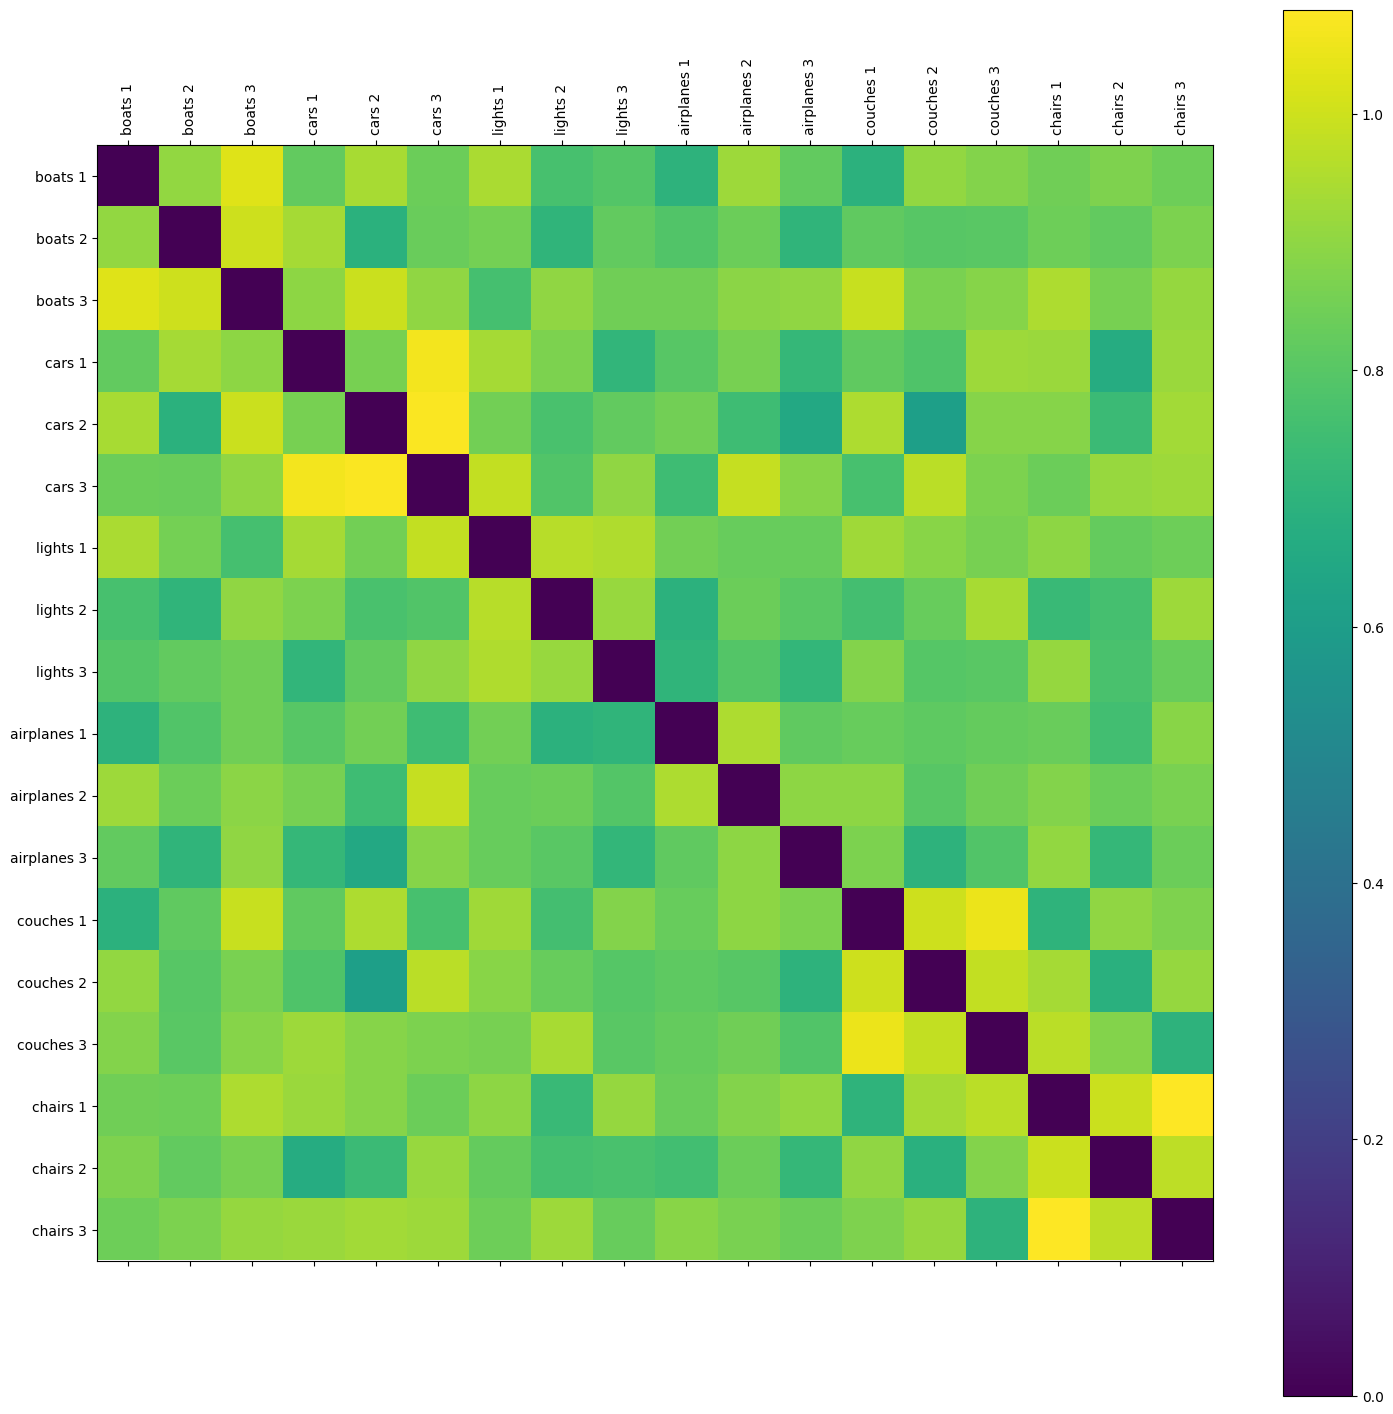

In [71]:
import matplotlib.pyplot as plt

labels = [cat + ' ' + str(x) for cat in cats for x in [1,2,3] ]

fig, ax = plt.subplots(figsize=rdm.shape)
cax = ax.matshow(rdm, interpolation='nearest')
ax.grid(False)
plt.xticks(range(rdm.shape[0]), labels, rotation=90)
plt.yticks(range(rdm.shape[0]), labels)
fig.colorbar(cax)
plt.show()


# Classification

In [185]:

#batchxchannelxWxH. take mean over W and H dims to get batchxchannel in the output
train_embs.shape

torch.Size([18, 2048])

In [175]:
train_X = train_embs.cpu()
train_y = torch.tensor([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5]) #torch.nn.functional.one_hot(torch.tensor([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5]), num_classes=6)

rand_idxs = torch.randperm(train_y.size()[0])
train_X=train_X[rand_idxs]
train_y=train_y[rand_idxs]

In [176]:
val_boats = torch.Tensor(np.array(read_data(VAL_DIR,2)['boats'])).to(device)
val_cars = torch.Tensor(np.array(read_data(VAL_DIR,2)['cars'])).to(device)
val_lights = torch.Tensor(np.array(read_data(VAL_DIR,2)['lights'])).to(device)
val_airplanes = torch.Tensor(np.array(read_data(VAL_DIR,2)['airplanes'])).to(device)
val_couches = torch.Tensor(np.array(read_data(VAL_DIR,2)['couches'])).to(device)
val_chairs = torch.Tensor(np.array(read_data(VAL_DIR,2)['chairs'])).to(device)

val_objects = [val_boats,val_cars,val_lights,val_airplanes,val_couches,val_chairs]

In [177]:
val_embs = img_encoder(resnext, val_objects)

val_X = val_embs.cpu()
val_y =  torch.tensor([0,0,1,1,2,2,3,3,4,4,5,5]) #torch.nn.functional.one_hot(torch.tensor([0,0,1,1,2,2,3,3,4,4,5,5]), num_classes=6)

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = LogisticRegression(fit_intercept=True,
                        multi_class='auto',
                        penalty='l2', #ridge regression
                        solver='saga',
                        max_iter=10000,
                        C=50)

clf.fit(train_X, train_y)

LogisticRegression(C=50, max_iter=10000, solver='saga')

In [179]:
print('Train acc:', clf.score(train_X, train_y))
print('Val acc:', clf.score(val_X, val_y))

Train acc: 1.0
Val acc: 0.4166666666666667


In [180]:
predictions = clf.predict(val_X)

cm = metrics.confusion_matrix(y_true=val_y, 
                         y_pred = predictions, 
                        labels = clf.classes_)
cm

array([[1, 0, 0, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 0]])

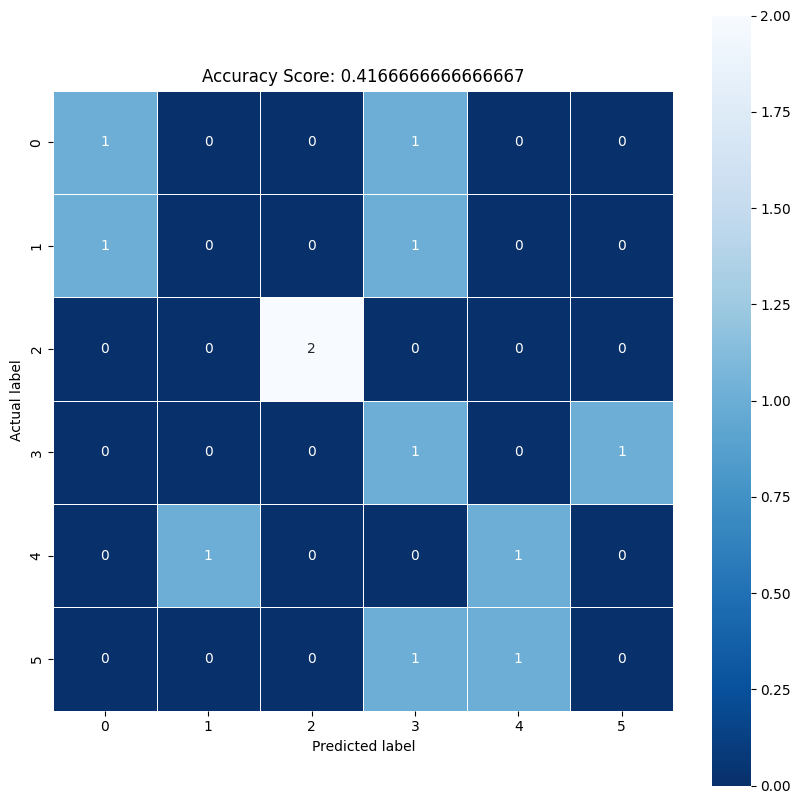

In [184]:
# !pip -q install seaborn
import seaborn as sns

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r');

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(clf.score(val_X, val_y))
plt.title(all_sample_title);


In [183]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_classification




# clf = make_pipeline(StandardScaler(), LinearSVC(dual="auto", random_state=0, tol=1e-5))
# clf.fit(X, y)
# print(clf.named_steps['linearsvc'].coef_)
# print(clf.named_steps['linearsvc'].intercept_)
